# Clinical Models

In [1]:
import warnings, pickle, os
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 300)

from IPython.display import display
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(rc={'figure.figsize':(10,10)})

import shap
import optuna

%load_ext autoreload
%autoreload 1

In [2]:
from utils.evaluation import plot_roc_curves, plot_pr_curves, plot_calibration_curves, plot_alert_rate, plot_confusion_matrix, evaluate_all_outcomes, evaluate_multiple, plot_calibrated_regression_coefficients, confusion_matrix_multiplot, plot_shap_features_joint, biggest_alert_rate_diff
from hyperparameter_tuning import tune_lgbm, tune_logisticregression
from utils.data_profiling import ensure_categorical_overlap, drop_exclusive_cols
from dataset import SCIData, SCICols
%aimport utils.evaluation, hyperparameter_tuning, dataset, utils.data_profiling

In [3]:
class Notebook:
    IMAGE_DIR = "images/clinical_models_auc"
    SAVE_IMAGES = False

    RUN_HYPERPARAMETERS = False
    HYPERPARAMETER_TIMEOUT = 60 * 30
    HYPERPARAMETER_TRIALS = 1000
    HYPERPARAMETER_NJOBS = 16
    HYPERPARAMETER_SCORE = 'roc_auc'

    SHAP_PLOTS_MAXDISPLAY = 20
    EVAL_N_RESAMPLES = 99

    MODELS = {}
    EXPLAINERS = {}
    Y_PREDS = {}


try:
    os.makedirs(Notebook.IMAGE_DIR)
except FileExistsError:
    pass


In [4]:
from sklearn.model_selection import train_test_split

sci = (
    SCIData(SCIData.quickload("data/sci_processed.h5").sort_values("AdmissionDateTime"))
    .mandate(SCICols.news_data_raw)
    .omit_ae()
)

scii = (
    sci.derive_critical_event(within=1, return_subcols=True)
    .augment_shmi(onehot=True)
    .omit_redundant()
    .raw_news()
    .categorize()
    .onehot_encode_categories()
)

sci_train, sci_test, _, y_test_mortality, _, y_test_criticalcare = train_test_split(
    scii.drop(["DiedWithinThreshold", "CriticalCare"], axis=1),
    scii.DiedWithinThreshold,
    scii.CriticalCare,
    test_size=0.33,
    random_state=42,
    shuffle=False,
)
sci_train, sci_test = SCIData(sci_train), SCIData(sci_test)

test_set_n_days = (
    sci.loc[sci_test.index].AdmissionDateTime.max() - sci.loc[sci_test.index].AdmissionDateTime.min()
).days



In [5]:
(X_train_lr, y_train), (X_test_lr, y_test) = (
    sci_train.impute_blood().xy(outcome="CriticalEvent", dropna=False, fillna=True),
    sci_test.impute_blood().xy(outcome="CriticalEvent", dropna=False, fillna=True)
)

(X_train_lgbm, y_train), (X_test_lgbm, y_test) = (
    sci_train.xy(outcome="CriticalEvent", dropna=False, fillna=False),
    sci_test.xy(outcome="CriticalEvent", dropna=False, fillna=False)
)

(X_train_news, _), (X_test_news, _) = (
    sci_train#.impute_news().impute_blood()
    .xy(
        outcome="CriticalEvent",
        x=SCICols.news_data_raw,
        dtype=float,
        dropna=False,
        fillna=False,
    ),
    sci_test#.impute_news().impute_blood()
    .xy(
        outcome="CriticalEvent",
        x=SCICols.news_data_raw,
        dtype=float,
        dropna=False,
        fillna=False,
    ),
)


In [108]:
from sklearn.metrics import precision_recall_curve, roc_curve


def get_threshold(y_train, y_pred_proba, target=0.85):
    """ Given prediction probabilities, sets the prediction threshold to approach the given target recall
    """

    # Get candidate thresholds from the model, and find the one that gives the best fbeta score
    precision, recall, thresholds = precision_recall_curve(y_train, y_pred_proba)
    closest = thresholds[np.abs(recall - target).argmin()]

    return closest

def get_threshold_fpr(y_train, y_pred_proba, target=0.15):
    fpr, tpr, thresholds = roc_curve(y_train, y_pred_proba)
    closest = thresholds[np.abs(fpr - target).argmin()]

    return closest


In [7]:
def benchmark(y_pred, y_pred_proba, modelkey, filekey, tuning=False):
    evaluate_all_outcomes(
        y_test,
        y_test_mortality,
        y_test_criticalcare,
        y_pred,
        y_pred_proba,
        modelkey,
        n_resamples=Notebook.EVAL_N_RESAMPLES,
        save=f"{Notebook.IMAGE_DIR}/eval_{filekey}.png"
        if Notebook.SAVE_IMAGES
        else None,
    )
    plot_confusion_matrix(
        y_test,
        y_pred,
        plot_title=modelkey,
        save=f"{Notebook.IMAGE_DIR}/matrix_{filekey}.png"
        if Notebook.SAVE_IMAGES
        else None,
    )

    if not tuning:
        Notebook.Y_PREDS[modelkey] = (y_pred, y_pred_proba)
    else:
        modelkey = f"{modelkey} (tuned)"
        y_pred = np.where(y_pred_proba > get_threshold(y_test, y_pred_proba), 1, 0)
        evaluate_all_outcomes(
            y_test,
            y_test_mortality,
            y_test_criticalcare,
            y_pred,
            y_pred_proba,
            modelkey,
            n_resamples=Notebook.EVAL_N_RESAMPLES,
            save=f"{Notebook.IMAGE_DIR}/eval_thresholded_{filekey}.png"
            if Notebook.SAVE_IMAGES
            else None,
        )
        plot_confusion_matrix(
            y_test,
            y_pred,
            plot_title=modelkey,
            save=f"{Notebook.IMAGE_DIR}/matrix_thresholded_{filekey}.png"
            if Notebook.SAVE_IMAGES
            else None,
        )
        Notebook.Y_PREDS[modelkey] = (y_pred, y_pred_proba)


# Models

## Baseline (NEWS)

,Accuracy,Precision,Recall,F1 Score,F2 Score,AUC,AUC_CI
Baseline (NEWS),,,,,,,
Critical event,0.969003,0.283916,0.217811,0.246509,0.228449,0.801963,0.802 (0.784-0.822)
Mortality only,0.983090,0.109091,0.661017,0.187275,0.328559,0.930540,0.931 (0.894-0.961)
Critical care,0.968154,0.187413,0.161836,0.173688,0.166377,0.784928,0.785 (0.766-0.806)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


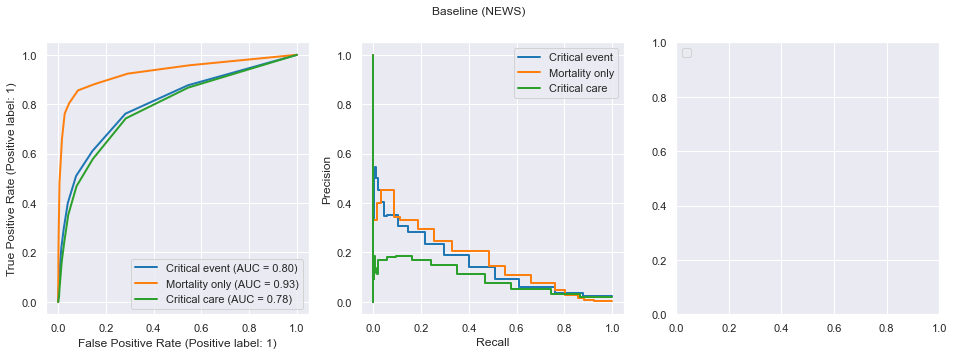

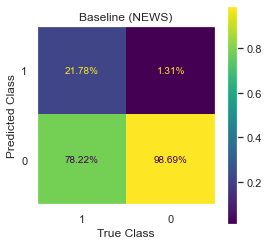

In [8]:
benchmark(
    (sci.loc[sci_test.index].NEWS_score >= 7).to_numpy(),
    sci.loc[sci_test.index].NEWS_score.to_numpy(),
    "Baseline (NEWS)",
    "news",
    tuning=False,
)


## Logistic Regression (NEWS only)

In [58]:
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV

lr_news_params = {
    'max_iter': 1000,
    'random_state': 42,
    'penalty': 'elasticnet',
    'solver': 'saga',
    'C': 9.9156,
    'l1_ratio': 0.8106,
    'class_weight': 'balanced',
}


if Notebook.RUN_HYPERPARAMETERS:
    lr_news_params.update(
        tune_logisticregression(
            X_train_news,
            y_train,
            timeout=Notebook.HYPERPARAMETER_TIMEOUT,
            n_jobs=Notebook.HYPERPARAMETER_NJOBS,
            n_trials=Notebook.HYPERPARAMETER_TRIALS,
            score=Notebook.HYPERPARAMETER_SCORE
        )
    )

modelkey = "NEWS Logistic Regression"
model = (
    CalibratedClassifierCV(
        LogisticRegression().set_params(**lr_news_params), cv=5, method='isotonic', n_jobs=Notebook.HYPERPARAMETER_NJOBS
    ).fit(X_train_news, y_train)
)
Notebook.MODELS[modelkey] = model


,Accuracy,Precision,Recall,F1 Score,F2 Score,AUC,AUC_CI
NEWS Logistic Regression,,,,,,,
Critical event,0.976646,0.363636,0.004292,0.008484,0.005349,0.820104,0.820 (0.802-0.834)
Mortality only,0.996978,0.363636,0.033898,0.062016,0.041408,0.906209,0.906 (0.860-0.941)
Critical care,0.979044,0.000000,0.000000,0.000000,0.000000,0.808344,0.808 (0.788-0.825)


,Accuracy,Precision,Recall,F1 Score,F2 Score,AUC,AUC_CI
NEWS Logistic Regression (tuned),,,,,,,
Critical event,0.573334,0.044660,0.849785,0.084860,0.184512,0.820104,0.820 (0.802-0.834)
Mortality only,0.559596,0.006203,0.932203,0.012324,0.030210,0.906209,0.906 (0.860-0.941)
Critical care,0.571136,0.039247,0.840580,0.074992,0.165352,0.808344,0.808 (0.788-0.825)


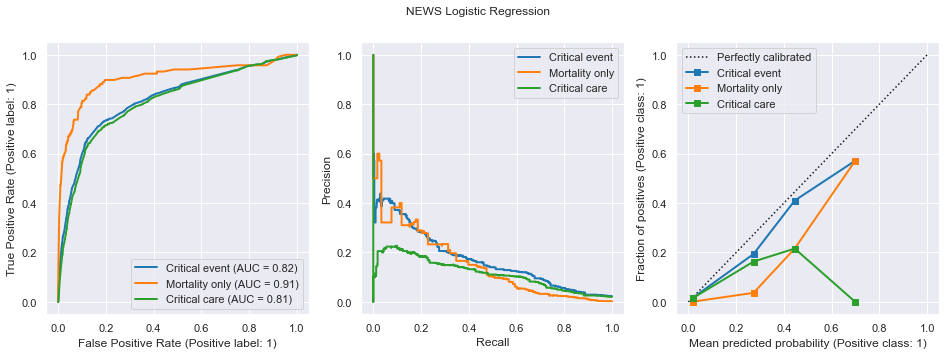

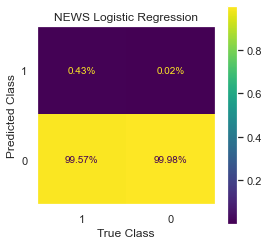

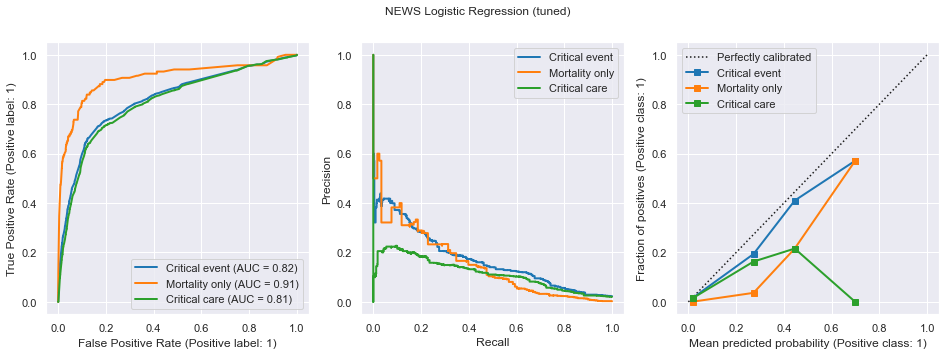

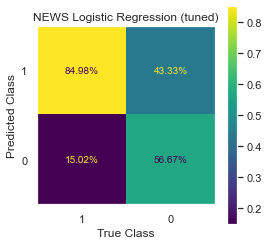

In [73]:
benchmark(
    model.predict(X_test_news),
    model.predict_proba(X_test_news)[:, 1],
    modelkey,
    "news_regression",
    tuning=True,
)



In [ ]:
plot_calibrated_regression_coefficients(model, X_train_news.columns, topn=10, figsize=(8,4), save = f'{Notebook.IMAGE_DIR}/logistic_regression_coef.png' if Notebook.SAVE_IMAGES else None)

The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

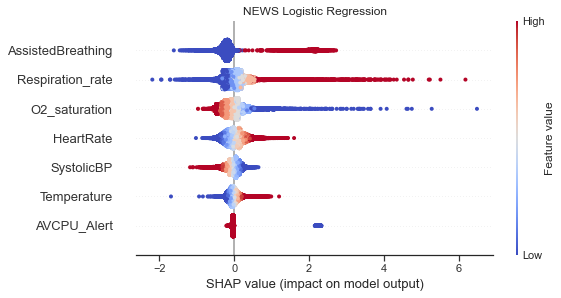

In [172]:
explainers = [
    shap.LinearExplainer(
        _.base_estimator, X_train_news, feature_perturbation='correlation_dependent'
    )(X_test_news)
    for _ in model.calibrated_classifiers_
]
shap_values = shap.Explanation(
    base_values = np.array([_.base_values for _ in explainers]).mean(axis=0),
    values = np.array([_.values for _ in explainers]).mean(axis=0),
    data = explainers[0].data,
    feature_names = X_train_news.columns
)
Notebook.EXPLAINERS[modelkey] = shap_values

fig = shap.plots.beeswarm(
    shap_values, max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False, color=plt.get_cmap('coolwarm')
)
plt.title("NEWS Logistic Regression")

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/shap_swarm_news_regression.png", bbox_inches="tight", dpi=200
    )


In [ ]:
fig = shap.plots.bar(
    shap_values, max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False
)
plt.title("NEWS Logistic Regression")

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/shap_bar_news_regression.png", bbox_inches="tight", dpi=200
    )


In [ ]:
plot_shap_features_joint(
    shap_values, 
    modelkey, 
    max_display=Notebook.SHAP_PLOTS_MAXDISPLAY,
    figsize=(16,5),
    wspace=-0.2,
    save = f'{Notebook.IMAGE_DIR}/shap_features_news_regression.png' if Notebook.SAVE_IMAGES else None
)

## Logistic Regression

In [59]:
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV

lr_params = {
    'max_iter': 5000,
    'random_state': 42,
    'penalty': 'l2',
    'solver': 'saga',
    'C': 5.879,
    'class_weight': 'balanced',
}


if Notebook.RUN_HYPERPARAMETERS:
    lr_params.update(
        tune_logisticregression(
            X_train_lr,
            y_train,
            timeout=Notebook.HYPERPARAMETER_TIMEOUT,
            n_jobs=Notebook.HYPERPARAMETER_NJOBS,
            n_trials=Notebook.HYPERPARAMETER_TRIALS,
            score=Notebook.HYPERPARAMETER_SCORE
        )
    )

modelkey = "Logistic Regression"
model = (
    CalibratedClassifierCV(
        LogisticRegression().set_params(**lr_params), cv=5, method='isotonic', n_jobs=Notebook.HYPERPARAMETER_NJOBS
    ).fit(X_train_lr, y_train)
)
Notebook.MODELS[modelkey] = model


In [ ]:
plot_calibrated_regression_coefficients(model, X_train_lr.columns, save = f'{Notebook.IMAGE_DIR}/logistic_regression_coef.png' if Notebook.SAVE_IMAGES else None)

,Accuracy,Precision,Recall,F1 Score,F2 Score,AUC,AUC_CI
Logistic Regression,,,,,,,
Critical event,0.977795,0.559557,0.216738,0.312452,0.247004,0.894642,0.895 (0.882-0.905)
Mortality only,0.990184,0.119114,0.364407,0.179541,0.258103,0.909172,0.909 (0.868-0.948)
Critical care,0.978544,0.457064,0.199275,0.277544,0.224612,0.891911,0.892 (0.881-0.904)


,Accuracy,Precision,Recall,F1 Score,F2 Score,AUC,AUC_CI
Logistic Regression (tuned),,,,,,,
Critical event,0.759042,0.076901,0.849785,0.141038,0.282313,0.894642,0.895 (0.882-0.905)
Mortality only,0.745154,0.010389,0.906780,0.020543,0.049670,0.909172,0.909 (0.868-0.948)
Critical care,0.756994,0.067871,0.844203,0.125640,0.256778,0.891911,0.892 (0.881-0.904)


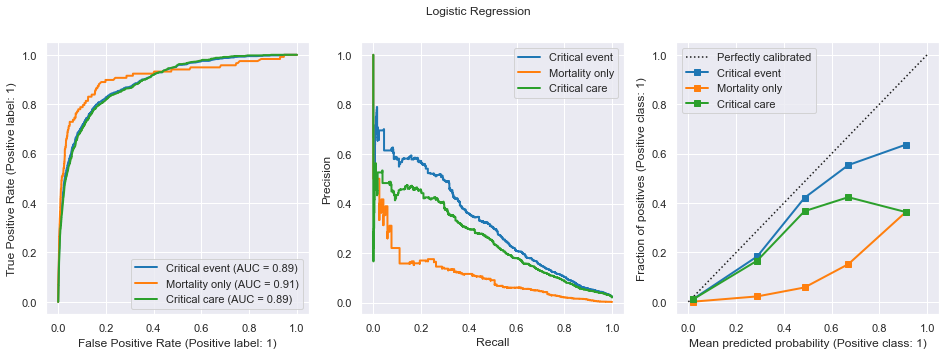

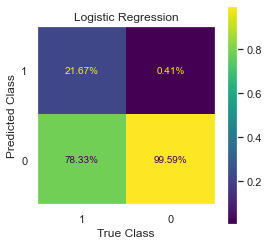

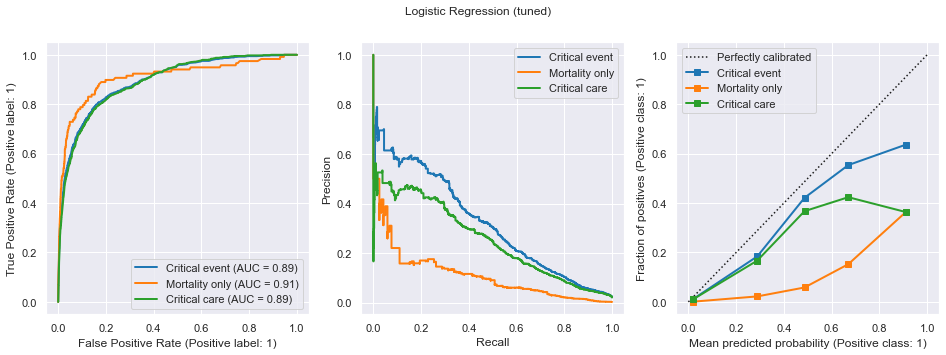

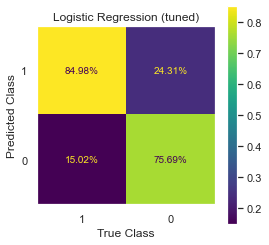

In [75]:
benchmark(
    model.predict(X_test_lr),
    model.predict_proba(X_test_lr)[:, 1],
    modelkey,
    "logistic_regression",
    tuning=True,
)



In [173]:
modelkey = 'Logistic Regression'
model = Notebook.MODELS[modelkey]

Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

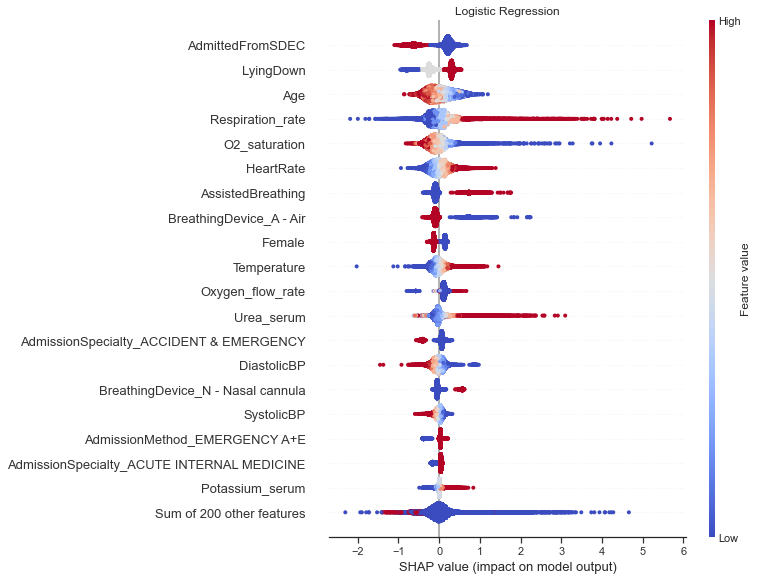

In [174]:
explainers = [
    shap.LinearExplainer(
        _.base_estimator, X_train_lr, feature_perturbation='correlation_dependent'
    )(X_test_lr)
    for _ in model.calibrated_classifiers_
]
shap_values = shap.Explanation(
    base_values = np.array([_.base_values for _ in explainers]).mean(axis=0),
    values = np.array([_.values for _ in explainers]).mean(axis=0),
    data = explainers[0].data,
    feature_names = X_train_lr.columns
)
Notebook.EXPLAINERS[modelkey] = shap_values

fig = shap.plots.beeswarm(
    shap_values, max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False, color=plt.get_cmap('coolwarm')
)
plt.title("Logistic Regression")

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/shap_swarm_logistic_regression.png", bbox_inches="tight", dpi=200
    )


In [ ]:
fig = shap.plots.bar(
    shap_values, max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False
)
plt.title("Logistic Regression")

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/shap_bar_logsitic_regression.png", bbox_inches="tight", dpi=200
    )


In [ ]:
plot_shap_features_joint(
    shap_values, 
    modelkey, 
    max_display=Notebook.SHAP_PLOTS_MAXDISPLAY,
    figsize=(16,8),
    wspace=-0.3,
    save = f'{Notebook.IMAGE_DIR}/shap_features_logistic_regression.png' if Notebook.SAVE_IMAGES else None
)

## LightGBM

In [62]:
from lightgbm import LGBMClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.calibration import CalibratedClassifierCV

lgbm_params = {
    'LGBM__objective': 'binary',
    'LGBM__verbose_eval': -1,
    'LGBM__random_state': 42,
    'LGBM__metrics': ['l2', 'auc'],
    'LGBM__boosting_type': 'gbdt',
    'LGBM__is_unbalance': True,
    'LGBM__n_jobs': 1,
    'LGBM__feature_pre_filter': False,
    'LGBM__lambda_l1': 1.793e-3,
    'LGBM__lambda_l2': 6.2266e-4,
    'LGBM__num_leaves': 14,
    'LGBM__feature_fraction': 0.41188,
    'LGBM__bagging_fraction': 0.97156,
    'LGBM__bagging_freq': 1,
    'LGBM__min_child_samples': 6,
    'IMB__sampling_strategy': 0.104
}

if Notebook.RUN_HYPERPARAMETERS:
    lgbm_params.update(
        tune_lgbm(
            X_train_lr,
            y_train,
            None,
            timeout=Notebook.HYPERPARAMETER_TIMEOUT,
            n_jobs=Notebook.HYPERPARAMETER_NJOBS,
            n_trials=Notebook.HYPERPARAMETER_TRIALS,
            score=Notebook.HYPERPARAMETER_SCORE
        )
    )

modelkey = "LightGBM"
model = (
    CalibratedClassifierCV(
        ImbPipeline(
            steps=[
                ("IMB", RandomUnderSampler()), 
                ("LGBM", LGBMClassifier())
            ]
        ).set_params(**lgbm_params),
        cv=5,
        method='isotonic',
        n_jobs=Notebook.HYPERPARAMETER_NJOBS
    ).fit(
        X_train_lgbm,
        y_train
    )
)

Notebook.MODELS[modelkey] = model


,Accuracy,Precision,Recall,F1 Score,F2 Score,AUC,AUC_CI
LightGBM,,,,,,,
Critical event,0.982491,0.720841,0.404506,0.518213,0.443425,0.922529,0.923 (0.912-0.933)
Mortality only,0.986038,0.078394,0.347458,0.127925,0.206030,0.925099,0.925 (0.890-0.951)
Critical care,0.983440,0.657744,0.415459,0.509252,0.448501,0.921009,0.921 (0.911-0.931)


,Accuracy,Precision,Recall,F1 Score,F2 Score,AUC,AUC_CI
LightGBM (tuned),,,,,,,
Critical event,0.814467,0.098020,0.849785,0.175766,0.335366,0.922529,0.923 (0.912-0.933)
Mortality only,0.800480,0.012995,0.889831,0.025616,0.061389,0.925099,0.925 (0.890-0.951)
Critical care,0.812519,0.086757,0.846618,0.157387,0.307672,0.921009,0.921 (0.911-0.931)


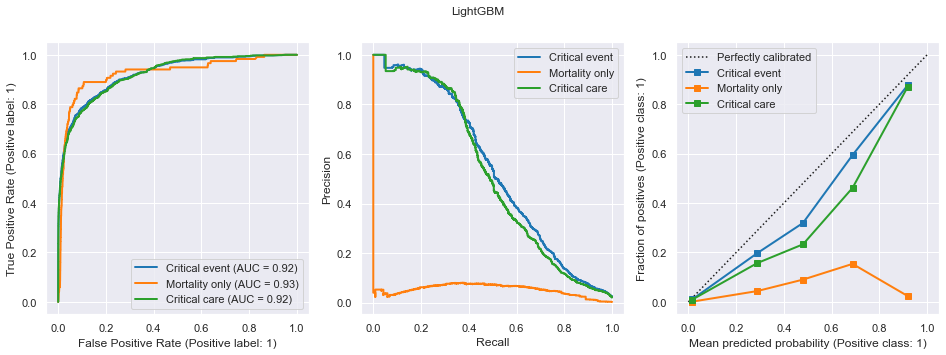

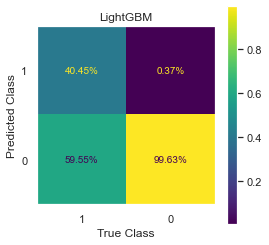

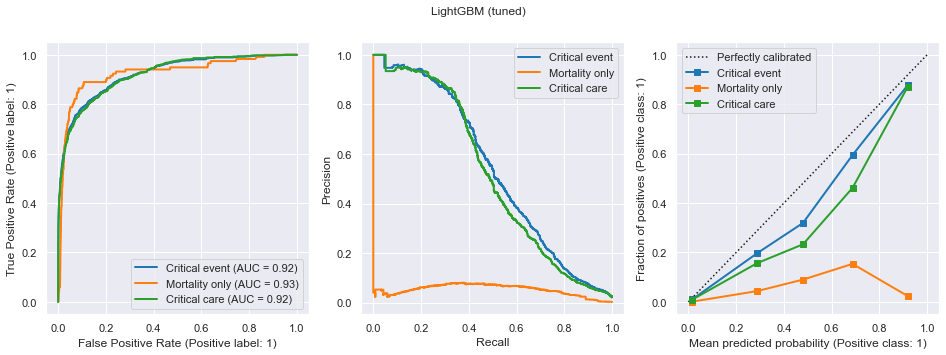

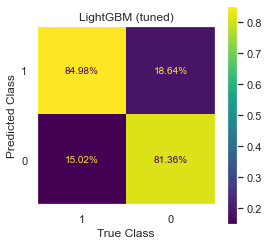

In [77]:
benchmark(
    model.predict(X_test_lgbm),
    model.predict_proba(X_test_lgbm)[:, 1],
    modelkey,
    "lightgbm",
    tuning=True,
)



In [218]:
cols = X_train_lgbm.columns.to_list()
cols = [_.replace('AdmissionSpecialty', 'AdmSpecialty').replace('EMERGENCY A+E', 'A&E').replace('ACCIDENT & EMERGENCY', 'A&E').replace('ACUTE INTERNAL MEDICINE', 'ACUTE').replace('GENERAL MEDICINE', 'MEDICINE').replace('AdmissionMethod', 'Pathway').replace('AdmittedFromSDEC', 'SentToSDEC') for _ in cols]


In [219]:
explainers = [
    shap.TreeExplainer(_.base_estimator['LGBM'])(X_test_lgbm)
    for _ in model.calibrated_classifiers_
]
shap_values = shap.Explanation(
    base_values = np.array([_.base_values for _ in explainers]).mean(axis=0),
    values = np.array([_.values for _ in explainers]).mean(axis=0),
    data = explainers[0].data,
    feature_names = cols
)
Notebook.EXPLAINERS[modelkey] = shap_values

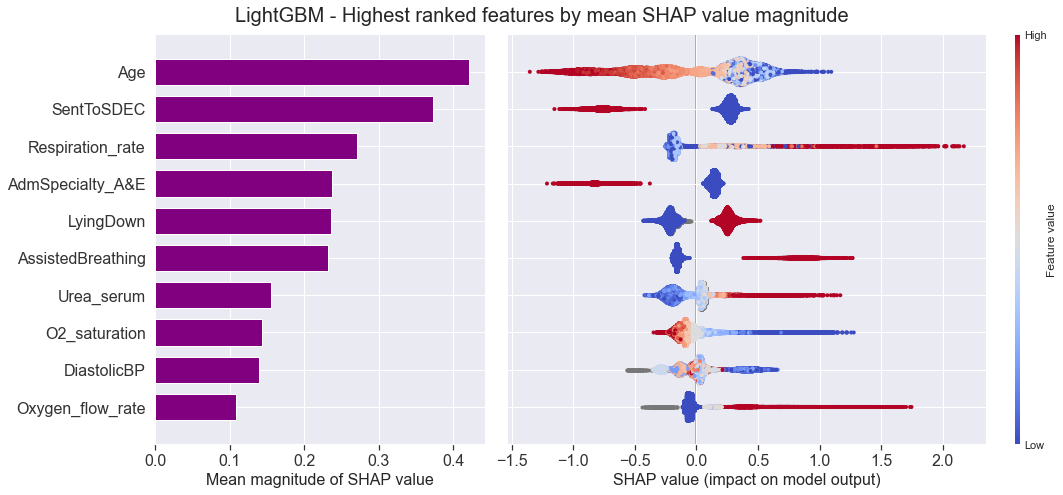

In [280]:
plot_shap_features_joint(
    shap_values[:, :, 1], 
    'LightGBM - Highest ranked features by mean SHAP value magnitude', 
    max_display=10,
    figsize=(16,7),
    wspace=-0.185,
    bar_aspect=0.050,
    topadjust=0.925,
    save = f'{Notebook.IMAGE_DIR}/shap_features_lightgbm_10.svg' if Notebook.SAVE_IMAGES else None,
    save_format='svg'
)

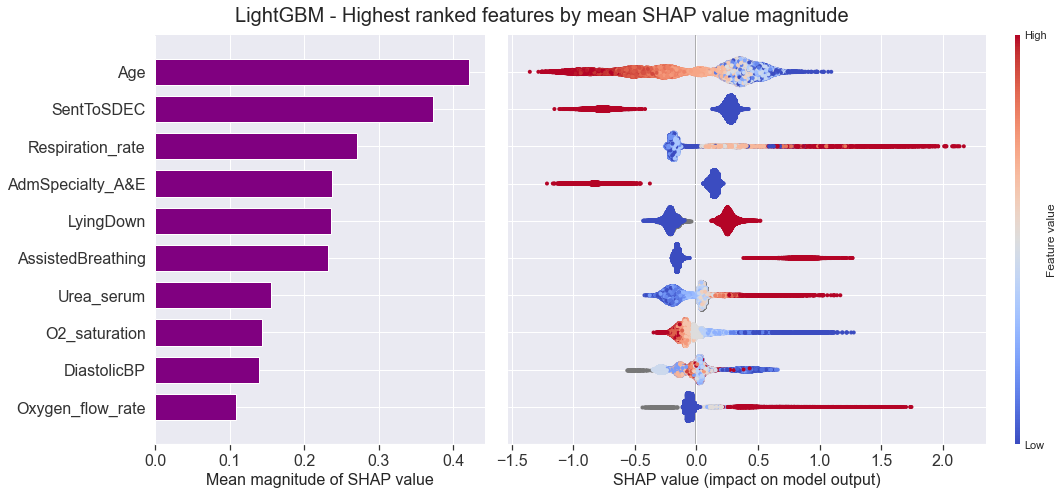

In [276]:
plot_shap_features_joint(
    shap_values[:, :, 1], 
    'LightGBM - Highest ranked features by mean SHAP value magnitude', 
    max_display=10,
    figsize=(16,7),
    wspace=-0.185,
    bar_aspect=0.050,
    topadjust=0.925,
    save = f'{Notebook.IMAGE_DIR}/shap_features_lightgbm_10.svg' if Notebook.SAVE_IMAGES else None,
    save_format='svg'
)

In [ ]:
fig = shap.plots.beeswarm(
    shap_values[:, :, 1], max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False, color=plt.get_cmap('coolwarm')
)
plt.title("LightGBM")
if Notebook.SAVE_IMAGES:
    plt.savefig(f"{Notebook.IMAGE_DIR}/shap_swarm_lightgbm.png", bbox_inches="tight", dpi=200)


In [ ]:
fig = shap.plots.bar(
    shap_values[:, :, 1], max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False
)
plt.title("LightGBM")

if Notebook.SAVE_IMAGES:
    plt.savefig(f"{Notebook.IMAGE_DIR}/shap_bar_lightgbm.png", bbox_inches="tight", dpi=200)


# Comparisons

In [166]:
Notebook.MODEL_DIR = 'models/clinical_models'

In [86]:
Notebook.Y_PREDS = dict(reversed(Notebook.Y_PREDS.items()))

In [ ]:
from utils.evaluation import evaluate_multiple

evaluate_multiple(
    y_test,
    Notebook.Y_PREDS,
    news_modelkey="Baseline (NEWS)",
    save=f"{Notebook.IMAGE_DIR}/combined_curves.png" if Notebook.SAVE_IMAGES else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
    alert_rate_n_days = test_set_n_days,
)



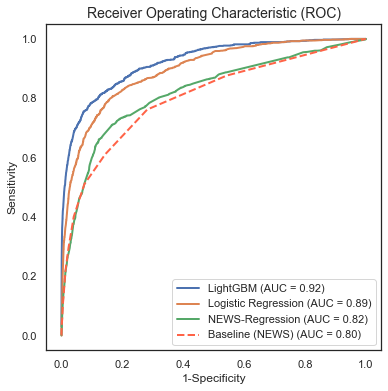

In [281]:
plot_roc_curves(y_test, Notebook.Y_PREDS, baseline_key='Baseline (NEWS)', save=f'{Notebook.IMAGE_DIR}/combined_roc.svg' if Notebook.SAVE_IMAGES else None, save_format='svg')

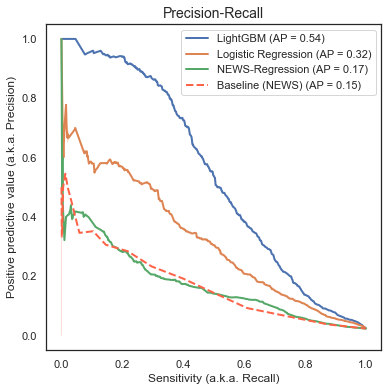

In [287]:
plot_pr_curves(y_test, Notebook.Y_PREDS, baseline_key='Baseline (NEWS)', save=f'{Notebook.IMAGE_DIR}/combined_pr.svg' if Notebook.SAVE_IMAGES else None, save_format='svg')

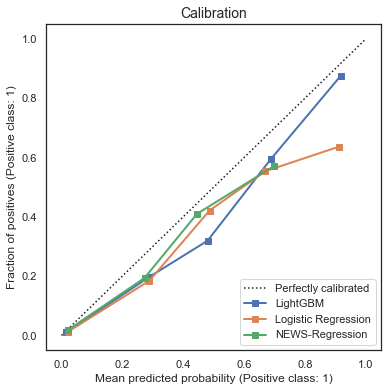

In [285]:
plot_calibration_curves(y_test, Notebook.Y_PREDS, save=f'{Notebook.IMAGE_DIR}/combined_calibration.svg' if Notebook.SAVE_IMAGES else None, save_format='svg')

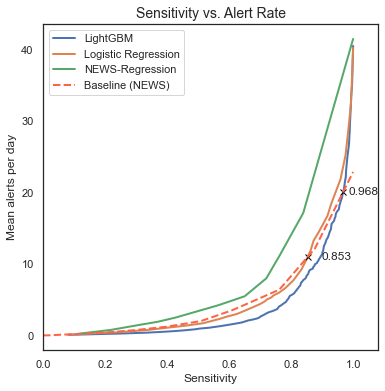

In [286]:
plot_alert_rate(y_test, Notebook.Y_PREDS, test_set_n_days, baseline_key='Baseline (NEWS)', save=f'{Notebook.IMAGE_DIR}/combined_alert_rate.svg' if Notebook.SAVE_IMAGES else None, save_format='svg')

In [88]:
sensitivity, news_rate, lgbm_rate = biggest_alert_rate_diff(y_test, Notebook.Y_PREDS['Baseline (NEWS)'][1], Notebook.Y_PREDS['LightGBM (tuned)'][1], test_set_n_days)
print(f'At sensitivity ~{sensitivity:.3f}: NEWS Alert rate: {news_rate:.3f}, LGBM Alert rate: {lgbm_rate:.3f} -> {100-(lgbm_rate*100/news_rate):.3f}% less')

At sensitivity ~0.762: NEWS Alert rate: 6.406, LGBM Alert rate: 4.160 -> 35.061% less


In [289]:
retune = lambda y_pred_proba: (np.where(y_pred_proba > get_threshold_fpr(y_test, y_pred_proba, target=0.1379), 1, 0), y_pred_proba)
# retuned = {
#     key: (np.where(y_pred_proba > get_threshold_fpr(y_test, y_pred_proba, target=0.1379), 1, 0), y_pred_proba)
#     for key, (_, y_pred_proba) in Notebook.Y_PREDS.items() if key != "Baseline (NEWS)"
# }
retuned = {}
retuned['Baseline (NEWS ≥ 7)'] = Notebook.Y_PREDS['Baseline (NEWS)']
retuned['NEWS-Regression'] = retune(Notebook.Y_PREDS['NEWS-Regression'][1])
#retuned['Logistic Regression'] = retune(Notebook.Y_PREDS['Logistic Regression (tuned)'][1])
retuned['LightGBM'] = retune(Notebook.Y_PREDS['LightGBM (tuned)'][1])

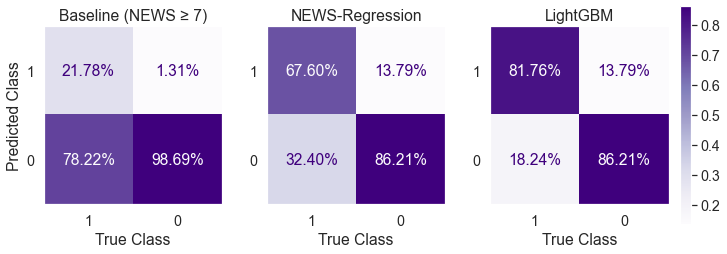

In [291]:
confusion_matrix_multiplot(y_test, retuned, save=f'{Notebook.IMAGE_DIR}/combined_matrices_3.png')

In [124]:
precision_score(y_test, retuned['LightGBM (tuned)'][0])

0.11629663192871167

## SHAP

In [274]:
def patient_force_plots(patient):
    patient_data = X_test_lr.loc[patient].apply(
        lambda x: f"{x:.2f}" if type(x) == np.float64 else x
    )
    patient_data.index = cols
    patient_idx = X_test_lr.index.get_loc(patient)

    explanations = {
        modelkey: shap_values[patient_idx]
        for modelkey, shap_values in Notebook.EXPLAINERS.items()
        if not modelkey in ["Baseline (NEWS)"]
    }
    for _ in explanations.keys():
        if len(explanations[_].shape) > 1:
            explanations[_] = explanations[_][:, 1]

    sns.set_style("white")
    plt.rc("axes", titlesize=16)
    for modelkey, explanation in explanations.items():
        patient_to_use = patient_data if modelkey != "NEWS-Regression" else patient_data[SCICols.news_data_raw]

        explanation = shap.Explanation(explanation)
        explanation.data = patient_to_use.values

        fig = shap.plots.force(
            explanation,
            feature_names=patient_to_use.index,
            matplotlib=True,
            contribution_threshold=0.05,
            show=False,
            text_rotation=15,
        )

        plt.title(modelkey)
        display(fig)

        if Notebook.SAVE_IMAGES:
            plt.savefig(
                f"{Notebook.IMAGE_DIR}/comaprison_force_plot_{modelkey.replace(' ','')}.svg",
                bbox_inches="tight", format='svg'
            )

        plt.clf()

    sns.set_style("darkgrid")

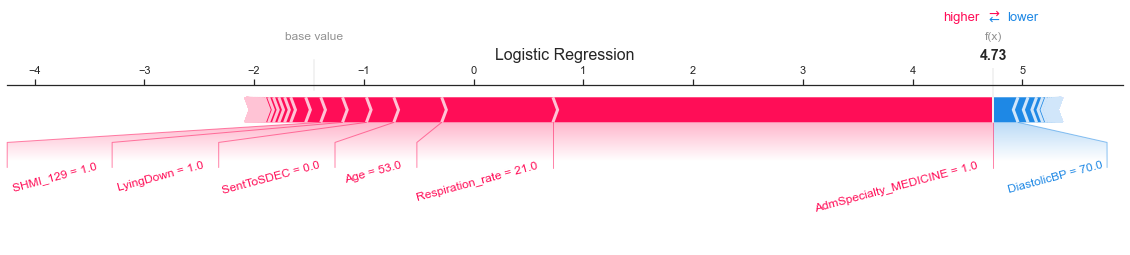

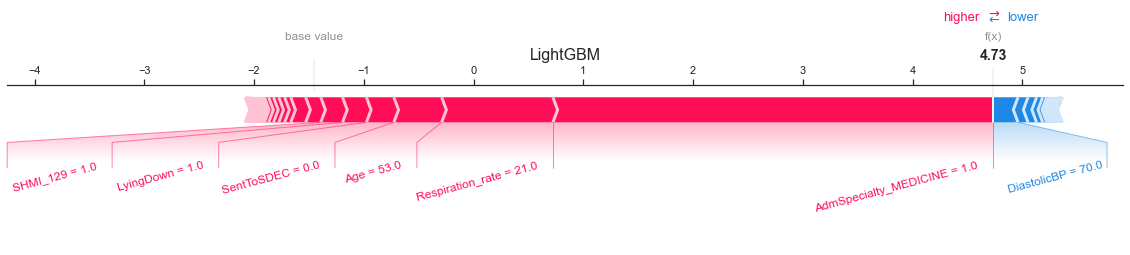

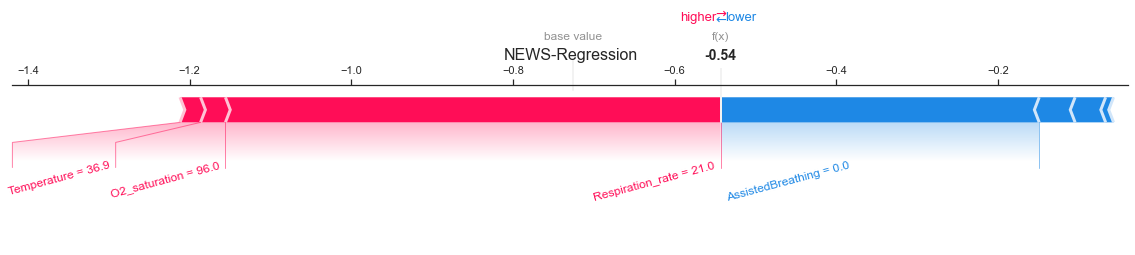

<Figure size 1440x216 with 0 Axes>

<Figure size 1440x216 with 0 Axes>

<Figure size 1440x216 with 0 Axes>

In [275]:
preds_df = pd.DataFrame({key:val[0] for key, val in Notebook.Y_PREDS.items()}).astype(bool).set_index(y_test.index)
candidate_mask = (
    preds_df['LightGBM (tuned)'] & 
    ~preds_df['Baseline (NEWS)'] & 
    y_test.astype(bool) &
    (X_test_lr.AssistedBreathing == 0)
)
candidates = preds_df[candidate_mask].index

patient_force_plots(55599)

In [ ]:
# def patient_decision_plots(patient):
#     patient_data = X_test_lr.loc[patient].apply(
#         lambda x: f"{x:.2f}" if type(x) == np.float64 else x
#     )
#     patient_idx = X_test_lr.index.get_loc(patient)

#     explanations = {
#         modelkey: shap_values[patient_idx]
#         for modelkey, shap_values in Notebook.EXPLAINERS.items()
#         if not modelkey in ["Baseline (NEWS)"]
#     }
#     for _ in explanations.keys():
#         if len(explanations[_].shape) > 1:
#             explanations[_] = explanations[_][:, 1]

#     sns.set_style("white")
#     plt.rc("axes", titlesize=16)
#     for modelkey, explanation in explanations.items():
#         patient_to_use = patient_data if modelkey != "NEWS Logistic Regression" else patient_data[SCICols.news_data_raw]
        
#         fig = plt.figure()
#         shap.decision_plot(explanation.base_values, explanation.values, explanation.data, explanation.feature_names, show=False)
#         plt.title(modelkey)
        
#         if Notebook.SAVE_IMAGES:
#             plt.savefig(
#                 f"{Notebook.IMAGE_DIR}/comaprison_force_plot_{modelkey.replace(' ','')}.png",
#                 bbox_inches="tight", dpi=200
#             )

#         #plt.clf()

# patient_decision_plots(55599)